In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
from os import listdir
from os.path import isfile, isdir, join

import re
import sys
sys.path.insert(0, '../supermodel_test/')
from supermodel import *
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

rc('font', **{'family':'serif','serif':['Helvetica']})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

%matplotlib inline

In [2]:
# load data

iontypes = ["K","Na"]#,"Ca","IH"]
data_dict = {}
for ion in iontypes:
    path = "/media/icg-channels/icg-channels-"+ion+"/"
    f = open("/media/icg-channels/icg-channels-"+ion+".pkl","rb")
    data_dict[ion] = pickle.load(f)


In [8]:
# get all errors

SM_NUM = 2
sm_str = "SM"+str(SM_NUM)
ERR_NUM = 3
err_str = "ERROR"+str(ERR_NUM)

total_icg_errors = []
manfit_errors = []
ss_errors = []
tau_errors = []
ss_popt = []
tau_popt = []
ss_data = []
tau_data = []
V_data = []

for i in range(len(iontypes)):
    ion = iontypes[i]
    files = list(data_dict[ion].keys())
    for j in range(len(files)):
        f = files[j]
        if (data_dict[ion][f]['RATES'] and data_dict[ion][f][sm_str+'_FIT']
           and data_dict[ion][f]['ICG_'+sm_str] and data_dict[ion][f]['ICG_ORIG']):
            tot_icg_err = data_dict[ion][f]['ICG_'+sm_str+'_MED__'+err_str]['total']
            ss_err = np.max(list(data_dict[ion][f][sm_str+'_'+err_str+'_SS'].values()))
            tau_err = np.max(list(data_dict[ion][f][sm_str+'_'+err_str+'_TAU'].values()))
            manfit_err = max(ss_err,tau_err)#0.5*(ss_err + tau_err)
            ss_p = list(data_dict[ion][f][sm_str+'_PARAMS_SS'].values())
            tau_p = list(data_dict[ion][f][sm_str+'_PARAMS_TAU'].values())
            ss_d = list(data_dict[ion][f]['RATE_VALS_SS'].values())
            tau_d = list(data_dict[ion][f]['RATE_VALS_TAU'].values())
            V_d = list(data_dict[ion][f]['RATE_VALS_V'].values())
            if (np.isnan(tot_icg_err) or tot_icg_err > 10.0):
                print('ICG error is fucked.')
            elif (np.isnan(ss_err) or np.isnan(tau_err) or ss_err > 1e20 or tau_err > 1e20):
                print('MANFIT error is fucked.')
            else:
                total_icg_errors.append(tot_icg_err)
                manfit_errors.append(manfit_err)
                ss_errors.append(ss_err)
                tau_errors.append(tau_err)
                ss_popt.append(ss_p)
                tau_popt.append(tau_p)
                ss_data.append(ss_d)
                tau_data.append(tau_d)
                V_data.append(V_d)

ss_fit_fcn = {1: sigmoid,2: modified_sigmoid,3: sigmoid,4: sigmoid,5: sigmoid}[SM_NUM]
tau_fit_fcn = {1:tau_fun3,2:tau_fun3,3:tau_fun2,4:tau_fun1,5:tau_fun4}[SM_NUM]

print('Total of %d files where everything works.' % len(total_icg_errors))

ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is 

[4.21970964] 0.21233651520806152
0.09214529809385408
0.3923834573960664


/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


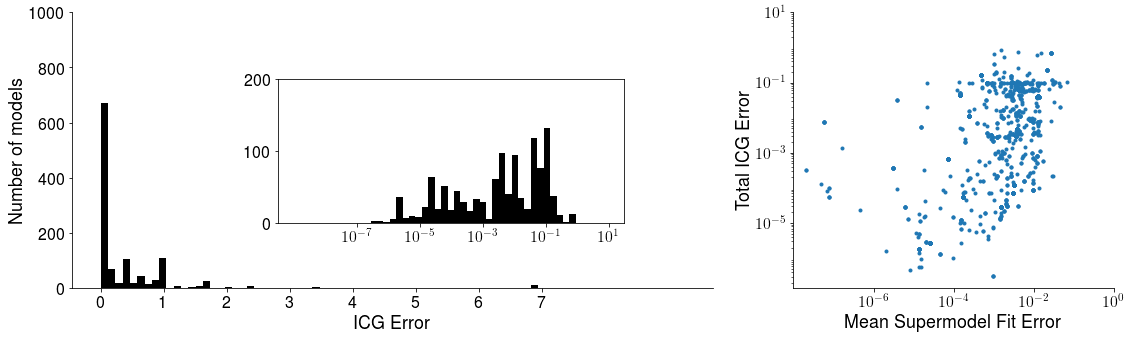

In [9]:
maxrange = 1.1*np.max(total_icg_errors)
matplotlib.rcParams.update({'font.size': 16})

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5), gridspec_kw = {'width_ratios':[2, 1]})
h = ax1.hist(total_icg_errors,range=(0,maxrange),bins=80,color='k')
plt.sca(ax1)
#plt.title('MSE for ICG protocols',fontsize=18)
plt.xlabel('ICG Error',fontsize=18)
plt.ylabel('Number of models',fontsize=18)
plt.xticks(np.arange(0,8,1),np.arange(0,8,1))
plt.yticks(np.arange(0,1001,200),np.arange(0,1001,200))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Insets
left, bottom, width, height = [0.25, 0.35, 0.3, 0.4]
ax1in = f.add_axes([left, bottom, width, height])
h = ax1in.hist(total_icg_errors,bins=np.logspace(-8,np.log10(maxrange)+1,50),color='k')
ax1in.set_xscale("log")
plt.xticks([10e-7,10e-5,10e-3,10e-1,10e1],[r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$',r'$10^{1}$'],fontsize=16)
plt.yticks(np.arange(0,201,100),np.arange(0,201,100),fontsize=16)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(manfit_errors).reshape(-1, 1),np.array(total_icg_errors))
print(reg.coef_, reg.intercept_)
print(reg.score(np.array(manfit_errors).reshape(-1, 1),np.array(total_icg_errors)))

plt.sca(ax2)
ax2.plot(manfit_errors,total_icg_errors,'.')
#ax2.plot(np.logspace(-7,0,101),reg.coef_[0]*np.logspace(-7,0,101) + reg.intercept_,'k-')
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.xticks([10e-6,10e-4,10e-2,10e-0],[r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$'],fontsize=16)
plt.yticks([10e-5,10e-3,10e-1,10e1],[r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$',r'$10^{1}$'],fontsize=16)
plt.xlabel('Mean Supermodel Fit Error',fontsize=18)
plt.ylabel('Total ICG Error',fontsize=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

print(np.mean(total_icg_errors))

plt.tight_layout()
f.savefig("fig4_icg_err.pdf",bbox_inches='tight')

[1.19258624] 0.3108441807711401
0.012412842379739275


/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


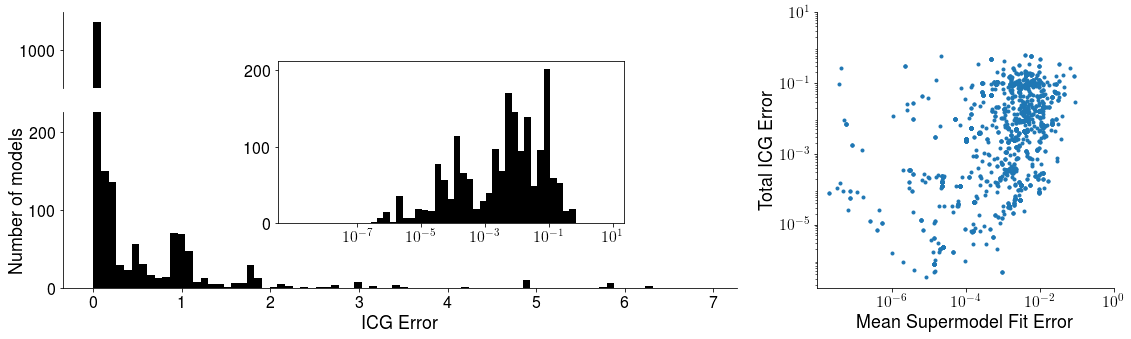

In [127]:
# plot the same with cutoff

maxrange = 1.1*np.max(total_icg_errors)
matplotlib.rcParams.update({'font.size': 16})

#f, axes = plt.subplots(2,2, figsize=(16,5), gridspec_kw = {'width_ratios':[2, 1]})
f = plt.figure(figsize=(16,5))
ax0 = plt.subplot2grid((3,3),(0,0),colspan=2)
h = ax0.hist(total_icg_errors,range=(0,maxrange),bins=80,color='k')
plt.sca(ax0)
ax0.set_ylim([950,1050])
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
plt.xticks([],[])
plt.yticks(np.arange(1000,1050,50),np.arange(1000,1050,50))
ax1 = plt.subplot2grid((3,3),(1,0),colspan=2,rowspan=2)
h = ax1.hist(total_icg_errors,range=(0,maxrange),bins=80,color='k')
plt.sca(ax1)
#plt.title('MSE for ICG protocols',fontsize=18)
ax1.set_ylim([0,225])
plt.xlabel('ICG Error',fontsize=18)
plt.ylabel('Number of models',fontsize=18)
plt.xticks(np.arange(0,8,1),np.arange(0,8,1))
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Insets
left, bottom, width, height = [0.25, 0.35, 0.3, 0.45]
ax1in = f.add_axes([left, bottom, width, height])
h = ax1in.hist(total_icg_errors,bins=np.logspace(-8,np.log10(maxrange)+1,50),color='k')
ax1in.set_xscale("log")
plt.xticks([10e-7,10e-5,10e-3,10e-1,10e1],[r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$',r'$10^{1}$'],fontsize=16)
plt.yticks(np.arange(0,201,100),np.arange(0,201,100),fontsize=16)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.array(manfit_errors).reshape(-1, 1),np.array(total_icg_errors))
print(reg.coef_, reg.intercept_)
print(reg.score(np.array(manfit_errors).reshape(-1, 1),np.array(total_icg_errors)))

ax2 = plt.subplot2grid((3,3),(0,2),rowspan=3)
plt.sca(ax2)
ax2.plot(manfit_errors,total_icg_errors,'.')
#ax2.plot(np.logspace(-7,0,101),reg.coef_[0]*np.logspace(-7,0,101) + reg.intercept_,'k-')
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.xticks([10e-6,10e-4,10e-2,10e-0],[r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$'],fontsize=16)
plt.yticks([10e-5,10e-3,10e-1,10e1],[r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$',r'$10^{1}$'],fontsize=16)
plt.xlabel('Mean Supermodel Fit Error',fontsize=18)
plt.ylabel('Total ICG Error',fontsize=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()
f.savefig("fig4_icg_err_cut.pdf",bbox_inches='tight')



K
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
Na
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
Ca
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
ICG error is fucked.
IH


/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


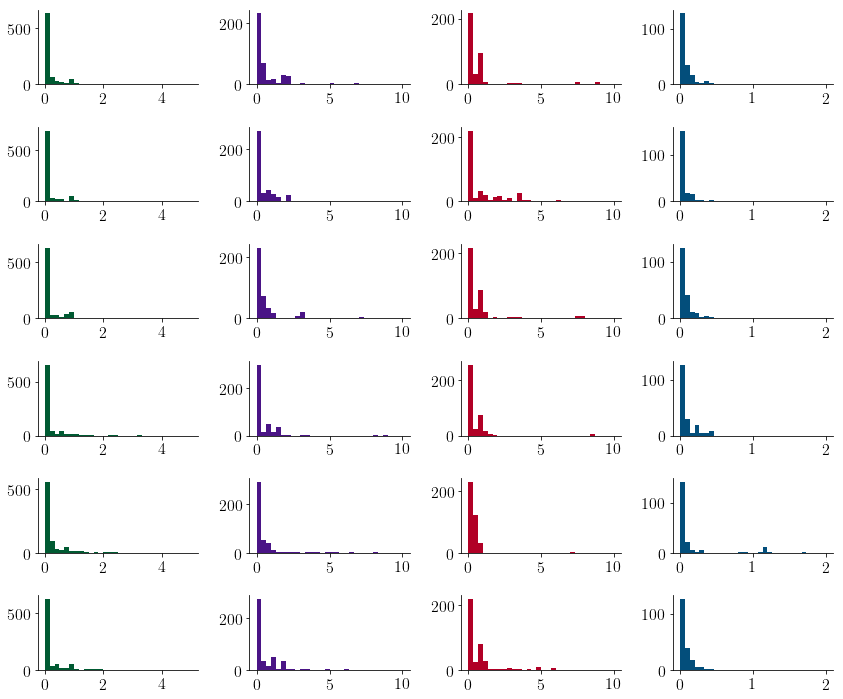

In [112]:
# plot separately for each ion type and protocol

protocols = ['act','deact','inact','ramp','ap','total']
cmap = {'K':['#005a32','#238443','#41ab5d','#78c679','#addd8e'],
        'Na':['#4a1486','#6a51a3','#807dba','#9e9ac8','#bcbddc'],
        'Ca':['#b10026','#e31a1c','#fc4e2a','#fd8d3c','#feb24c'],
        'IH':['#034e7b','#0570b0','#3690c0','#74a9cf','#a6bddb']}

xlim_list = [5,10,10,2]

f = plt.figure(figsize=(12,10))
for i in range(len(iontypes)):
    ion = iontypes[i]
    files = list(data_dict[ion].keys())
    print(ion)
    for j in range(len(protocols)):
        p = protocols[j]
        icg_errors = []
        for k in range(len(files)):
            f = files[k]
            if (data_dict[ion][f]['RATES'] and data_dict[ion][f][sm_str+'_FIT']
               and data_dict[ion][f]['ICG_'+sm_str] and data_dict[ion][f]['ICG_ORIG']):
                icg_err = data_dict[ion][f]['ICG_'+sm_str+'_'+err_str][p]
                if (np.isnan(icg_err) or icg_err > 100.0):
                    print('ICG error is fucked.')
                else:
                    icg_errors.append(icg_err)
        maxrange = 1.1*np.max(icg_errors)
        ax = plt.subplot(6,4,4*j+i+1)
        plt.hist(icg_errors,range=(0,xlim_list[i]),bins=30,color=cmap[ion][0])
        #plt.xlabel('ICG Error',fontsize=18)
        #plt.ylabel('Number of models',fontsize=18)
        #plt.xticks(np.arange(0,8,1),np.arange(0,8,1))
        #plt.yticks(np.arange(0,1001,200),np.arange(0,1001,200))
        #ax.set_xlim([0,xlim_list[i]])
        #plt.title(ion+p)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
plt.tight_layout()
f.savefit("traub_fits.pdf",bbox_inches='tight')
        
        